# **<h1 align="center">Data Mining 2024-25</h3>**
## **<h3 align="center">Customer Segmentation - ABCDEats Inc.</h3>**
### **<h3 align="center">Clustering</h3>**


**Group 10 members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Marco Galão  - r20201545@novaims.unl.pt - r20201545<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub  - 20240505@novaims.unl.pt - 20240505<br>

<a id = "toc"></a>

# Table of Contents

* [1. Import the Libraries](#import_libraries)
* [2. Import the Dataset](#import_dataset)
* [3. Clustering](#clustering)
    * [3.1 SOM](#som)
    * [3.2 RFM](#rfm)
    * [3.3 Mean Shift](#mean_shift)
    * [3.4 Hierarchical Clustering](#hierarchical_clustering)
    * [3.5 K-medoids](#k_medoids)
    * [3.6 DBSCAN](#dbscan)
    





# 1. Import the Libraries <a class="anchor" id="import_libraries"></a>
[Back to ToC](#toc)<br>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom
from matplotlib.patches import RegularPolygon, Ellipse

import warnings
warnings.filterwarnings("ignore")

#Importing the functions created in main.py
from main import *
import importlib
imported_module = importlib.import_module("main")
importlib.reload(imported_module)

<module 'main' from '/Users/svengoerdes/Projects/Master/Data_Mining_Project/deliverables/main.py'>

In [6]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

# 2. Import the Dataset <a class="anchor" id="import_dataset"></a>
[Back to ToC](#toc)<br>

In this section, we import the preprocessed dataset and set the customer_id as the index column. Also, check the first and last 5 rows of the dataset.

In [7]:
df_clustering = pd.read_csv("../Data/Preprocessed_Data.csv", index_col="customer_id")
df_clustering.head().T

customer_id,1b8f824d5e,f6d1b2ba63,180c632ed8,4eb37a6705,6aef2b6726
customer_region,2360,4660,4660,4660,8670
customer_age,18,38,26,20,40
vendor_count,2,1,2,2,2
product_count,5,2,3,5,2
chain_orders,1,2,1,0,0
...,...,...,...,...,...
prop_cui_japanese,0.0,0.0,0.0,0.0,0.0
prop_cui_noodle dishes,0.0,0.0,0.0,0.0,0.0
prop_cui_other,0.0,0.0,0.0,0.0,0.0
prop_cui_street food / snacks,0.0,0.0,0.0,0.0,0.0


In [8]:
df_clustering.tail().T

customer_id,f4e366c281,f6b6709018,f74ad8ce3f,f7b19c0241,fd40d3b0e0
customer_region,8670,8670,8670,8670,4660
customer_age,30,26,24,34,30
vendor_count,1,1,1,1,1
product_count,1,1,1,1,1
chain_orders,1,0,1,0,0
...,...,...,...,...,...
prop_cui_japanese,0.0,0.0,0.0,0.0,0.0
prop_cui_noodle dishes,0.0,0.0,0.0,0.0,0.0
prop_cui_other,0.0,0.0,0.0,0.0,0.0
prop_cui_street food / snacks,0.0,0.0,0.0,0.0,0.0


# 3. Clustering <a class="anchor" id="clustering"></a>
[Back to ToC](#toc)<br>

In [ ]:
# 

In [9]:
#Placeholder for the features that will be used in the clustering
metric_features = None
categorical_features = None
unused_features = None

> ## 3.1 SOM <a class="anchor" id="som"></a>
[Back to 3. Clustering](#clustering)<br>

In [10]:
from minisom import MiniSom
import numpy as np

def train_som(data, features, M=10, N=10, neighborhood_function='gaussian', 
              topology='hexagonal', learning_rate=0.5, iterations=20000, random_seed=42):
    """
    Trains a Self-Organizing Map (SOM) on the given dataset.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the features for SOM training.
        metric_features (list): List of metric feature column names to be used for training.
        M (int): Number of rows in the SOM grid. Default is 10.
        N (int): Number of columns in the SOM grid. Default is 10.
        neighborhood_function (str): The neighborhood function to use (e.g., 'gaussian', 'bubble').
        topology (str): The topology of the SOM grid ('rectangular' or 'hexagonal').
        learning_rate (float): Initial learning rate. Default is 0.5.
        iterations (int): Number of training iterations. Default is 20000.
        random_seed (int): Random seed for reproducibility. Default is 42.
    
    Returns:
        MiniSom: Trained MiniSom instance.
    """
    n_feats = len(metric_features)
    som_data = data[metric_features].values

    # Initialize the SOM
    sm = MiniSom(M, N, n_feats, learning_rate=learning_rate, 
                 topology=topology, neighborhood_function=neighborhood_function, 
                 activation_distance='euclidean', random_seed=random_seed)
    
    # Initialize weights
    sm.random_weights_init(som_data)
    
    # Quantization and topographic errors before training
    print("Before training:")
    print("QE:", np.round(sm.quantization_error(som_data), 4))
    print("TE:", np.round(sm.topographic_error(som_data), 4))
    
    # Train the SOM
    sm.train_batch(som_data, iterations)
    
    # Quantization and topographic errors after training
    print("After training:")
    print("QE:", np.round(sm.quantization_error(som_data), 4))
    print("TE:", np.round(sm.topographic_error(som_data), 4))
    
    return sm


In [ ]:
# define the metric features to be used in SOM --- > this is a placeholder for now 
metric_features = ['prop_cui_asian',
       'prop_cui_beverages', 'prop_cui_cafe', 'prop_cui_chicken dishes',
       'prop_cui_chinese', 'prop_cui_desserts', 'prop_cui_healthy',
       'prop_cui_indian', 'prop_cui_italian', 'prop_cui_japanese',
       'prop_cui_noodle dishes', 'prop_cui_other',
       'prop_cui_street food / snacks', 'prop_cui_thai']

In [13]:
sm = train_som(df_clustering, metric_features, M=10, N=10, neighborhood_function='gaussian')

Before training:
QE: 0.1921
TE: 0.8522
After training:
QE: 0.1297
TE: 0.2943


In [ ]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 




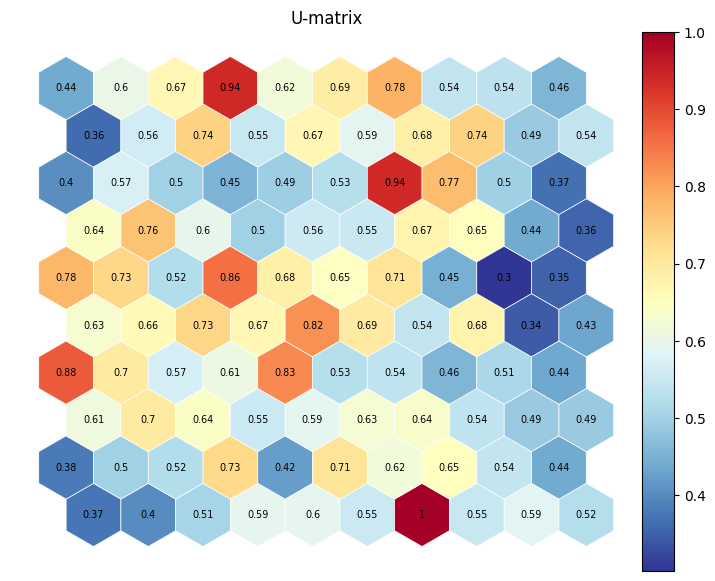

In [15]:
figsize=(10,7)

umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

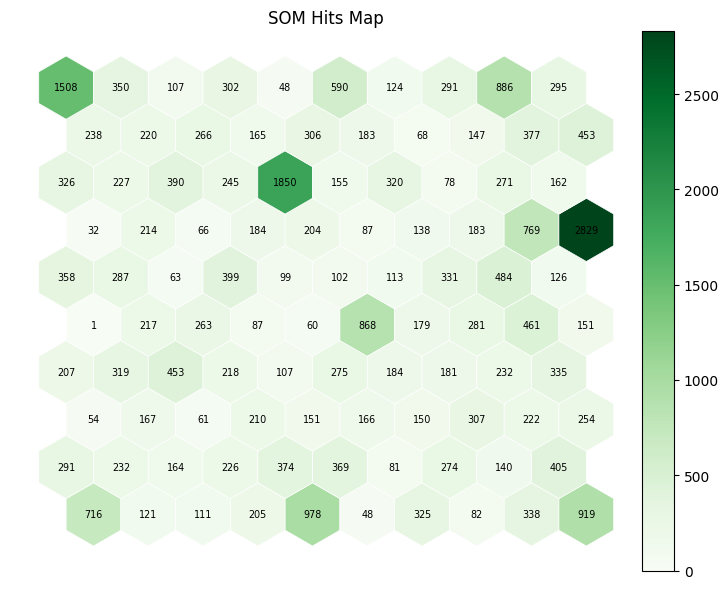

In [ ]:
hitsmatrix = sm.activation_response(df_clustering[metric_features].values)

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

In [17]:
# What are these weights?
weights = sm.get_weights()
weights.shape

(10, 10, 14)

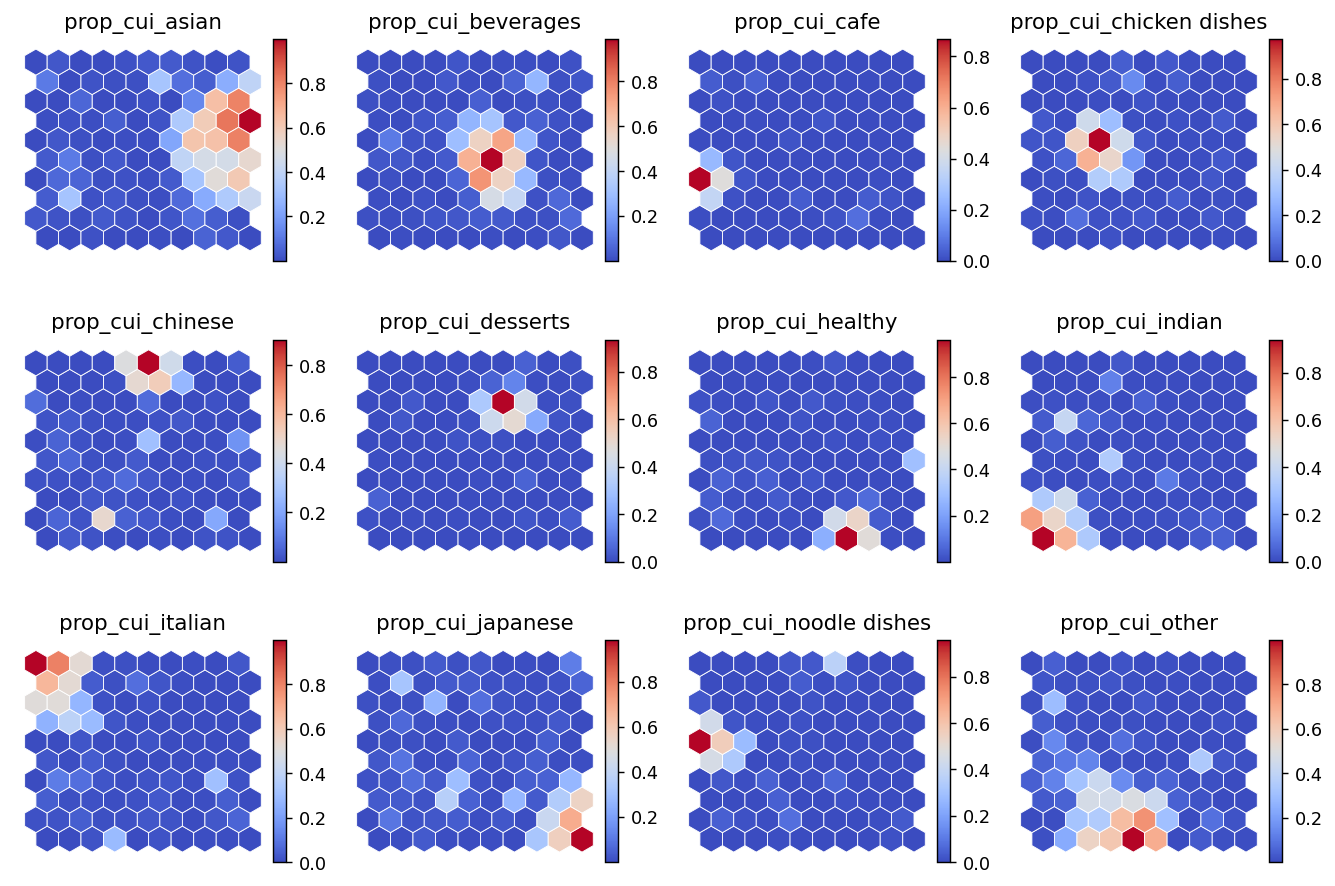

In [19]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

> ## 3.2 RFM <a class="anchor" id="rfm"></a>
[Back to 3. Clustering](#clustering)<br>

RFM (Recency, Frequency, and Monetary) analysis is a customer segmentation technique that evaluates customer behavior based on three dimensions:
1. **Recency (R)**: How recently a customer made a purchase. More recent activity indicates a higher likelihood of engagement.
   - **Feature**: `order_recency`
   - **Description**: Time since the customer's last order, identifying recent engagement.

2. **Frequency (F)**: How often a customer makes purchases. Frequent customers are more likely to be loyal.
   - **Feature**: `total_orders`
   - **Description**: Total number of orders placed, measuring customer activity.

3. **Monetary (M)**: How much money a customer spends. Higher spending reflects greater customer value.
   - **Feature**: `total_cui_spending`
   - **Description**: Total spending by the customer, reflecting their monetary contribution.

These features allow us to evaluate customer behavior and create actionable clusters to target specific segments for personalized strategies.


In [ ]:
# Binning Recency, Frequency, and Monetary
M_segmentation = pd.qcut(rfm_data['Monetary'], q=3, labels=False) +1  # High = high value
R_segmentation = pd.qcut(rfm_data['Recency'], q=3, labels=False) +1  # Recent = better
F_segmentation = pd.qcut(rfm_data['Frequency'], q=3, labels=False) +1  # High = frequent

#Combine into RFM Segmentation
rfm_segmentation = pd.DataFrame(
    {'Monetary': M_segmentation, 'Recency': R_segmentation, 'Frequency': F_segmentation}
)

#Add Original Values
rfm_segmentation['monetary_value'] = rfm_data['Monetary']
rfm_segmentation['customer_recency'] = rfm_data['Recency']
rfm_segmentation['customer_frequency'] = rfm_data['Frequency']

# Create RFM Segment Labels
rfm_segmentation['segment'] = (
    rfm_segmentation['Recency'].astype(str)
    + "-" + rfm_segmentation['Frequency'].astype(str)
    + "-" + rfm_segmentation['Monetary'].astype(str)
)

# Calculate Correlation Matrix
rfm_corr = rfm_segmentation[['monetary_value', 'customer_recency', 'customer_frequency']].corr()

print("Correlation Matrix for RFM Metrics:")
rfm_corr


Correlation Matrix for RFM Metrics:


,monetary_value,customer_recency,customer_frequency
monetary_value,1.000000,0.305804,0.735328
customer_recency,0.305804,1.000000,0.368504
customer_frequency,0.735328,0.368504,1.000000



The correlation matrix between the RFM metrics (Recency, Frequency, and Monetary) reveals the following insights:

- **Monetary and Frequency** have a high correlation (r = 0.735), indicating overlap in the information they provide.
- **Frequency and Recency** have a moderate correlation (r = 0.368).
- **Monetary and Recency** have the lowest correlation (r = 0.306), suggesting they provide more distinct insights.

To simplify the analysis and focus on the most distinct metrics, we will:
1. Remove **Frequency** due to its high correlation with Monetary.
2. Create a bubble plot using only **Recency** and **Monetary**, which represent distinct customer behaviors.

This simplification aligns with the approach used in the previous project, where only the most relevant dimensions were retained for clustering and visualization.

In [ ]:
rfm_segmentation.describe()

,Monetary,Recency,Frequency,monetary_value,customer_recency,customer_frequency
count,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000,31236.000000
mean,1.999968,1.987899,1.848668,38.262395,0.708210,4.364931
std,0.816529,0.809845,0.846156,45.841673,0.257466,5.013391
min,1.000000,1.000000,1.000000,0.370000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,13.030000,0.544444,2.000000
50%,2.000000,2.000000,2.000000,24.180000,0.777778,3.000000
75%,3.000000,3.000000,3.000000,45.020000,0.922222,5.000000
max,3.000000,3.000000,3.000000,1418.330000,1.000000,94.000000


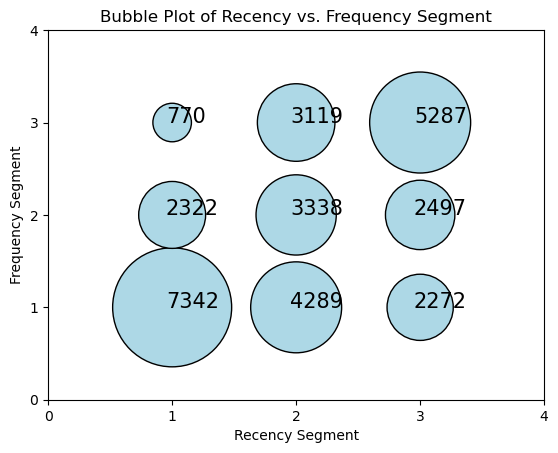

In [ ]:
def create_2d_bubble(rf_segment, variable, multiplier, colorbubble):
  '''
  Creates 2-dimensional bubble plot with detailed
  RF segment information.

  Arguments:
  - rf_segment(pd.DataFrame): Dataframe with segments
  data.
  - variable(str): Variable to use as bubble size.
  - multiplier(int): Multiplier to add emphasis to the 
  bubble size.
  - colorbubble(str): color of the bubble plot

  Returns:
  - None, but a plot is shown.
  '''
  fig, ax = plt.subplots()

  # Create the scatter plot 
  # Multiplying by 25 just to see more difference between
  # bubbles
  sc = ax.scatter(rf_segment.Recency, 
            rf_segment.Frequency, 
            s=rf_segment[variable]*multiplier,
            color=colorbubble,
            edgecolors='black')

  # Annotate plot with size
  for i in range(len(rf_segment.Recency)):
    ax.annotate(np.round(rf_segment[variable].iloc[i], 1),
                (rf_segment.Recency.iloc[i]-0.05,
                rf_segment.Frequency.iloc[i]),
                fontsize=15
                )

  plt.title('Bubble Plot of Recency vs. Frequency Segment')
  plt.xlabel('Recency Segment')
  plt.ylabel('Frequency Segment')
  plt.xticks([0,1,2,3,4])
  plt.yticks([0,1,2,3,4])

  plt.show()
  
# Step 1: Aggregate data for Frequency and Recency groups
segment_size = rfm_segmentation.groupby(['Frequency', 'Recency'], as_index=False).size()
segment_value = rfm_segmentation.groupby(['Frequency', 'Recency'], as_index=False)['monetary_value'].mean()

# Merge size and monetary value
segment_info = segment_size.merge(segment_value, on=['Frequency', 'Recency'])

# Step 2: Create a bubble plot for size
create_2d_bubble(segment_info, 'size', 1, 'lightblue')  # Bubbles sized by number of customers

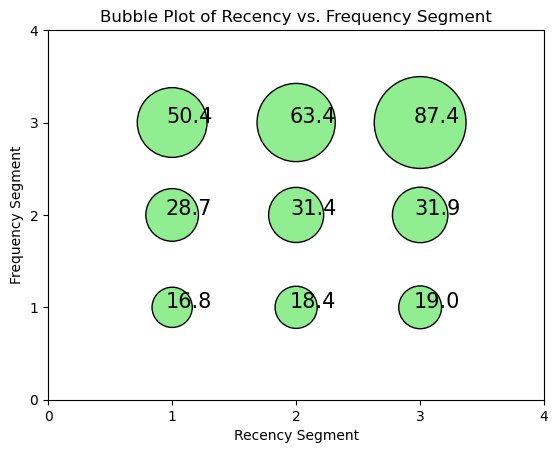

In [ ]:
# Create a bubble plot for monetary value
create_2d_bubble(segment_info, 'monetary_value', 50, 'lightgreen')  # Bubbles sized by average monetary value

> ## 3.3 Mean Shift <a class="anchor" id="mean_shift"></a>
[Back to 3. Clustering](#clustering)<br>

> ## 3.4 Hierarchical Clustering <a class="anchor" id="hierarchical_clustering"></a>
[Back to 3. Clustering](#clustering)<br>

In [ ]:
df_hierarchicalClustering = df_clustering.copy()

Find best linkage method

In [ ]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(df_hierarchicalClustering[metric_features], 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

Define number of clusters based on dendogram

In [ ]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'


hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_hierarchicalClustering[metric_features])

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



In [ ]:
# Plot the corresponding dendrogram
sns.set_theme()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [ ]:
##########################################
# Visualize the Dendrogram with y_threshold = 75
##########################################

# Plot the corresponding dendrogram
sns.set_theme()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

Test cluster solution for different amount of clusters

In [ ]:
linkage = 'ward'
distance = 'euclidean'

In [ ]:
# 4 cluster solution
n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels = hc4_clust.fit_predict(df_hierarchicalClustering[metric_features])

In [ ]:
# Characterizing the 4 clusters
df_hierarchicalClustering_concat = pd.concat([df_hierarchicalClustering[metric_features], 
                       pd.Series(hc4_labels, 
                                 name='labels', 
                                 index=df_hierarchicalClustering.index)], 
                    axis=1)

df_hierarchicalClustering_concat.groupby('labels').mean()

In [ ]:
# 5 cluster solution
n_clusters=5

hc5_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc5_labels = hc5_clust.fit_predict(df_hierarchicalClustering[metric_features])

In [ ]:
# Characterizing the 5 clusters
df_hierarchicalClustering_concat = pd.concat([df_hierarchicalClustering[metric_features], 
                       pd.Series(hc5_labels, 
                                 name='labels', 
                                 index=df_hierarchicalClustering.index)], 
                    axis=1)

df_hierarchicalClustering_concat.groupby('labels').mean()

In [ ]:
pd.crosstab(
    pd.Series(hc5_labels, name='hc5_labels', index=df_hierarchicalClustering.index),
    pd.Series(hc4_labels, name='hc4_labels', index=df_hierarchicalClustering.index),
    )

Final Hierarchical clustering solution

In [ ]:
# final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 4

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df_hierarchicalClustering[metric_features])

In [ ]:
# Characterizing the final clusters

df_hierarchicalClustering_concat = pd.concat([
    df_hierarchicalClustering[metric_features], 
    pd.Series(hc_labels, name='labels', index=df_hierarchicalClustering.index)
    ], 
    axis=1)
df_hierarchicalClustering_concat.groupby('labels').mean()

> ## 3.5 K-medoids <a class="anchor" id="k_medoids"></a>
[Back to 3. Clustering](#clustering)<br>

> ## 3.6 DBSCAN <a class="anchor" id="dbscan"></a>
[Back to 3. Clustering](#clustering)<br>